# Cardiotocography under a microscope
---
This is a short study of the heart rate and other characteristics of 2126 fetuses. The fetuses are classified in 10 classes of heart behavior, and 3 classes of disease risk ( NSP ). For more information on the parameters of the dataset, they are widely explained in the dataset description.

In a first part we will explore our dataset to try to find some valuable insights hidden in the numbers. To do that we will use dimensionality reduction, first through PCA, then using an autoencoder. We will analyze the results and compare them to our original dataset.

In a second part we will try to model a tool that could be useful in detecting the possible pathology. In order to do this, we will test a number of Machine Learning classifiers, we will try to find the most accurate for this problem and then tune it to its best accuracy. We will then compare the results of the best classifier we found with the results of a small artificial neural network and see which one does best. 


**Importing the libraries and dataset**
---

Here we want to do a very basic preprocessing of the data and take a general look at the shape of the problem.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_excel(r'archive/CTG.xls', sheet_name=1, skiprows=1) # Get the data

In [60]:
dataset.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,Unnamed: 9,...,E,AD,DE,LD,FS,SUSP,Unnamed: 42,CLASS,Unnamed: 44,NSP
0,240.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,NaN,9.0,NaN,2.0
1,5.0,632.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
2,177.0,779.0,2.0,0.0,5.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
3,411.0,1192.0,2.0,0.0,6.0,2.0,0.0,0.0,0.0,NaN,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,6.0,NaN,1.0
4,533.0,1147.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,2.0,NaN,1.0


We see that a few "extra" columns have been processed and that they don't contain any relevant information ( or any information at all for that matter ).
Let's clean up the dataset.

In [61]:
dataset = dataset.dropna(axis=1, how='all') # Got rid of empty columns
dataset = dataset.dropna(axis=0, how='any') # Three rows were REALLY missing information
dataset = dataset.drop(['b','e','DR','Tendency'], axis=1) # No information from such columns...

In [62]:
dataset.head()

,AC,FM,UC,DL,DS,DP,LB,AC.1,FM.1,UC.1,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.000000,0.0,0.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,9.0,2.0
1,4.0,0.0,4.0,2.0,0.0,0.0,132.0,0.006380,0.0,0.006380,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
2,2.0,0.0,5.0,2.0,0.0,0.0,133.0,0.003322,0.0,0.008306,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
3,2.0,0.0,6.0,2.0,0.0,0.0,134.0,0.002561,0.0,0.007682,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,4.0,0.0,5.0,0.0,0.0,0.0,132.0,0.006515,0.0,0.008143,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0


Much better.

**Data exploration**
---
In this part we are going to explore the dataset in a way that would make it more understable. For this purpose we are going to use correlations and graphic representations of the dataset. Since our dataset is composed of 38 columns, we will either choose which one to represent or use different dimensionality reduction techniques to present it on a 3D or 2D plot.

Distrubution of the different classes
---

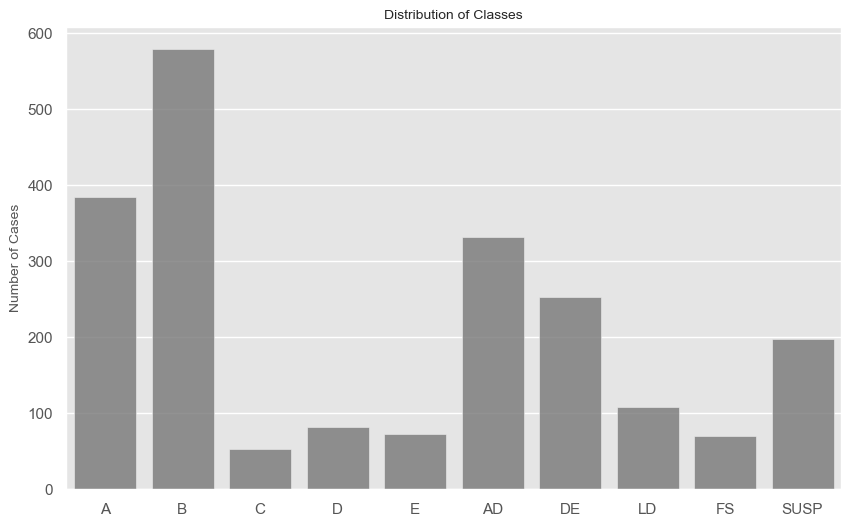

In [63]:
import matplotlib.cm as cm # To make pretty graphs
import seaborn as sns
color = sns.color_palette()

cnt_srs = dataset['CLASS'].value_counts()
cnt_srs = cnt_srs.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[3])
N = 10
ind = np.arange(N) 
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'))
plt.ylabel('Number of Cases', fontsize=10)
plt.title('Distribution of Classes', fontsize=10)
plt.show()

A wide majority of our cases is represented by the fetus classes B, A, AD, and DE. We want to know what they are made of to fully understand the distribution of the problem.

**Distribution of the patholgies in the general problem**

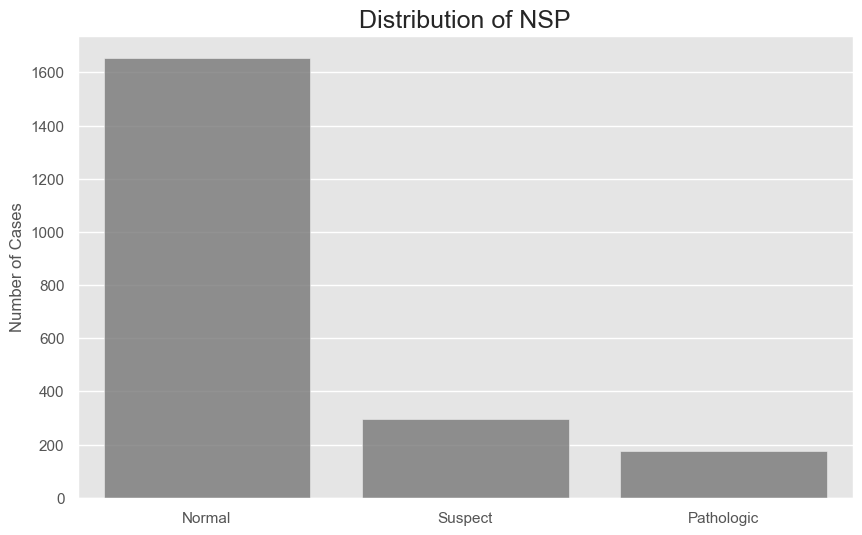

In [64]:
import matplotlib.cm as cm # To make pretty graphs
import seaborn as sns
color = sns.color_palette()

cnt_srs = dataset['NSP'].value_counts()
cnt_srs = cnt_srs.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[3])
N = 3
ind = np.arange(N) 
plt.xticks(ind, ('Normal','Suspect', 'Pathologic'))
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Distribution of NSP', fontsize=18)
plt.show()

A large majority of our dataset shows a normal behavior while suspect and pathologic behavior are more rare.

Distribution of the NSP in the fetus classes
---

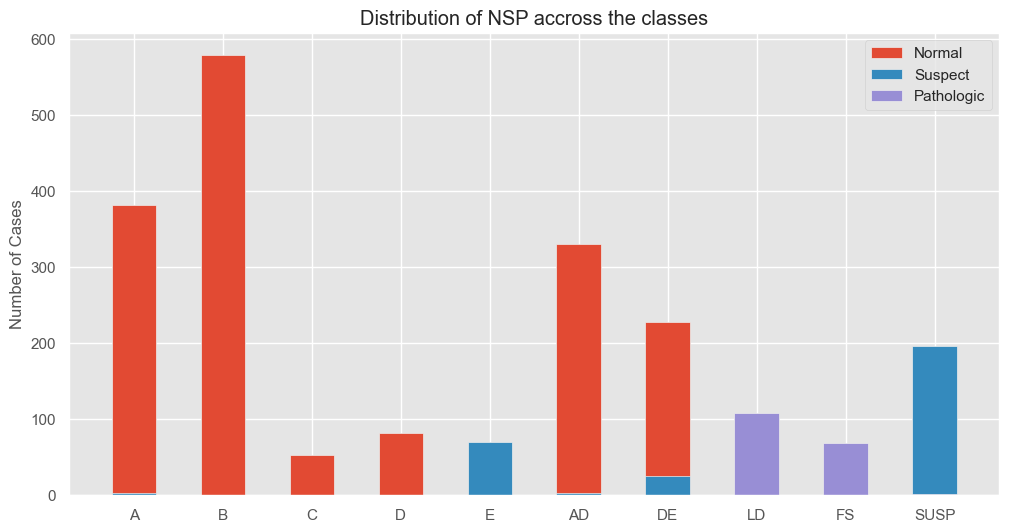

In [65]:
x = dataset[['CLASS','NSP']]
N = 10
zeroesddf = pd.DataFrame(data=np.zeros(10,),index=[1,2,3,4,5,6,7,8,9,10])

ind = np.arange(N)    # the x locations for the groups
width = 0.50    # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,6))

for nsp_i in [1,2,3]:
    norm = x.loc[(x['NSP']==nsp_i)].drop('NSP', axis=1)
    norm = (pd.value_counts(norm['CLASS'].values, sort=False)).sort_index()
    norm = pd.DataFrame(data=norm, index=norm.index)
    norm = zeroesddf.add(norm,axis='index',fill_value=0) 
    norm = (norm.values).reshape(-1)
    if nsp_i == 1 :
        p1 = plt.bar(ind,norm, width)
    elif nsp_i == 2 :
        p2 = plt.bar(ind,norm,width)
    elif nsp_i == 3 :
        p3 = plt.bar(ind,norm,width)
    
plt.ylabel('Number of Cases')
plt.title('Distribution of NSP accross the classes')
plt.xticks(ind, ('A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'))
plt.legend((p1[0], p2[0], p3[0]), ('Normal', 'Suspect', 'Pathologic'))
plt.show()

For some of the classes the interpretation was obvious from start. As such the "SUSP" class contains a wide majority of cases classified as suspect, and LD and FS are mostly composed of cases classified as pathologic.

Two classes present interesting and different results. The "E" class, mostly composed of suspect cases but with a different behaviour, and the "DE" class that amongst a wide variety of cases classified as normal also contains a non negligeable amount of suspect cases.

Correlation map
---

Building the correlation map will help us understand which parameters are the most essential in determining if a fetus has a pathological behavior. Thankfully, the NSP parameter that describes the heatlth of the fetus is in increasing numerical order, and can be easily interpreted through this map. It can also help us understand what makes the other 10 classes by showing clearly their most relevant features.

C:\Users\Incre\AppData\Local\Temp\ipykernel_8676\859486704.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

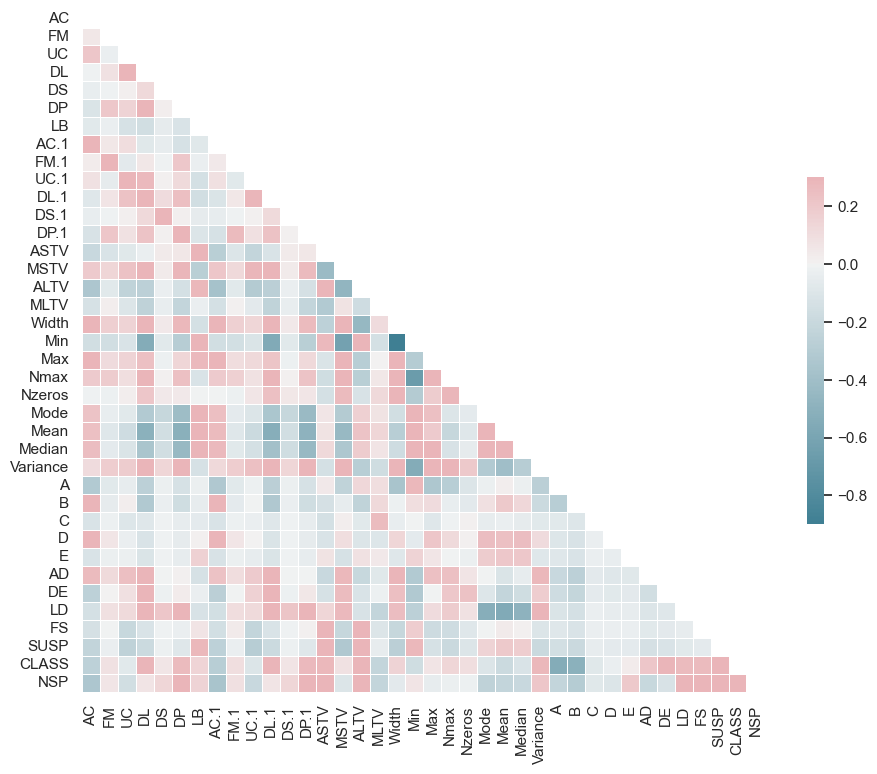

In [66]:
sns.set(style="white")
# Generate a large random dataset
d = dataset

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The map does not show any strong positive correlation between the parameters describing the fetus and its NSP class. The highest we can see on the map are the DP value(number of prolongued decelerations per second) and ALTV value (percentage of time with abnormal long term variability).

Let's keep an eye on these values.

Dimensionality Reduction
---
Can we get a clear representation of our data using dimensionality reduction techniques ? 
In this part, we will try a few of them.

First we need to process the data to a format that can fit these algorithms.

In [67]:
# Preparing our variables
X = dataset.iloc[:,:-2].values # We got rid of the class value to focus on the FHR diagnosis
y = dataset.iloc[:,-1].values # Containing the FHR diagnosis

# Splitting the dataset into the Training set and Test set
# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Applying Kernel PCA**

We will use the different kernels available in sklearn to see if any of them can help us represent the data.

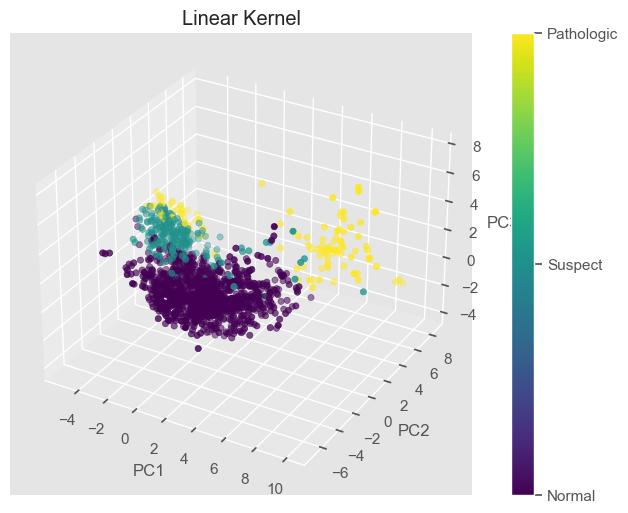

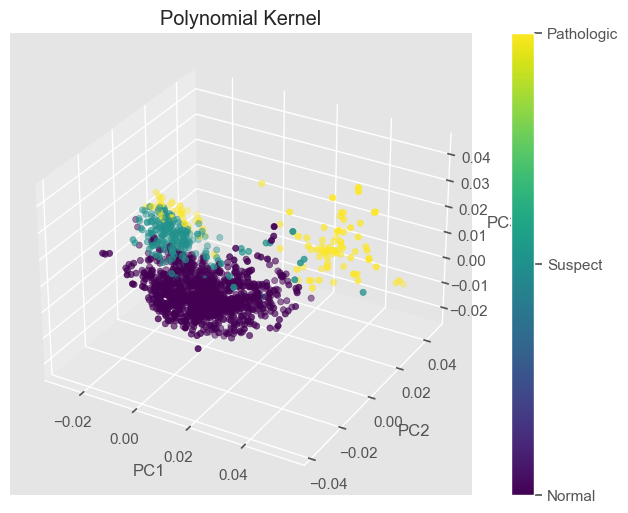

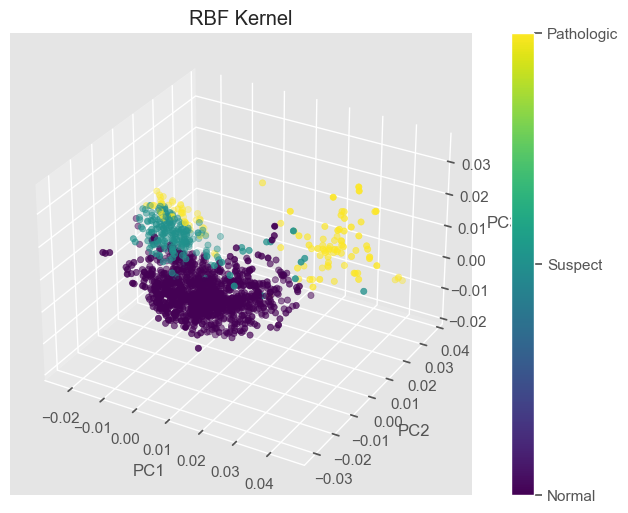

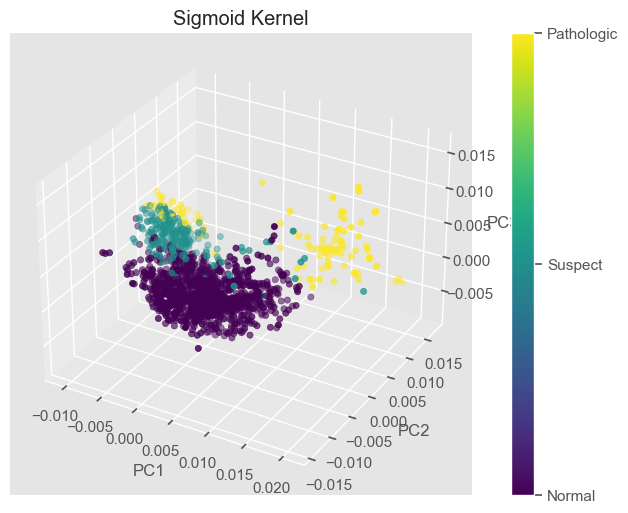

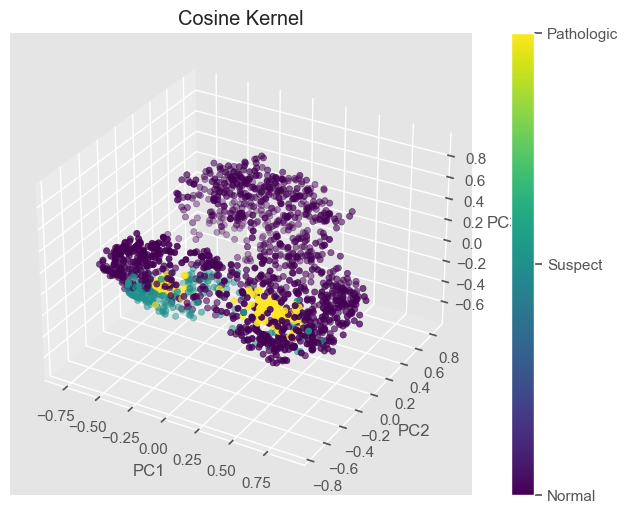

In [68]:
from sklearn.decomposition import KernelPCA

names = [
         'Linear Kernel',
         'Polynomial Kernel',
         'RBF Kernel',
         'Sigmoid Kernel',
         'Cosine Kernel'
         ]

classifiers = [
    KernelPCA(n_components = 3, kernel = 'linear'),
    KernelPCA(n_components = 3, kernel = 'poly', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'rbf', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'sigmoid', gamma= 0.00001),
    KernelPCA(n_components = 3, kernel = 'cosine')
]

models=zip(names,classifiers)
   
for name, kpca in models:
    X_PCA = kpca.fit_transform(X_train)
    
    from mpl_toolkits.mplot3d import axes3d
    from matplotlib import style
    style.use('ggplot')
    
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111, projection='3d')
    loc = [1,2,3]
    classes = ['Normal','Suspect','Pathologic']
    x3d = X_PCA[:,0]
    y3d = X_PCA[:,1]
    z3d = X_PCA[:,2]

    plot = ax1.scatter(x3d, y3d, z3d, c=y_train, cmap="viridis")
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    cb = plt.colorbar(plot)
    cb.set_ticks(loc)
    cb.set_ticklabels(classes)

    plt.title(name)
    plt.show()

Regardless of the kernels we used as examples and regardless of the different parameters we tried for such kernels off-screen, we could not get the PCA technique to represent the problem on a 3D graph in a way that was clear and understandable. We added the colors on the graphs to show where the different NSP groups were represented. It clearly shows that the PCA did not perform efficiently when it comes to separate the NSP groups. Yet, something interesting came out of it. Every kernel we used created two different groups for the "Pathologic" class of the NSP. One is always close to the "Suspect" group of points and one is always far from it. It shows a subclassification amongst the "Suspect" group, some of them being more prone to evolve in a pathology than others.


**Using an Autoencoder for Dimensionality reduction**

Autoencoders have proven their efficiency in many different cases. When it comes to dimensionality reduction we have yet to find a technique more elegant and more accurate. We're gonna build an autoencoder from scratch, use it to encode the data that we will then put on a 3D graph to compare it with our previous results. From here, we will refer to the autoencoder as AE.

In [69]:
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np  # You need to import numpy for 'np.delete'
from sklearn.model_selection import train_test_split

X = dataset.iloc[:, :-1].values  # Put back the class value to use it later

# Feature scaling for the AE
sX = minmax_scale(X, axis=0)
ncol = 36
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(sX, y, train_size=0.8, random_state=seed(2017))

Class_train_auto = X_train_auto[:, 36]  # These two columns will be used for comparison
Class_test_auto = X_test_auto[:, 36]  # later on

X_train_auto = np.delete(X_train_auto, 36, 1)  # But they are not needed
X_test_auto = np.delete(X_test_auto, 36, 1)  # as of right now

input_dim = Input(shape=(ncol,))

# Define the dimension of the encoder
encoding_dim = 3

# Define the encoder layer
encoded = Dense(encoding_dim, activation='relu')(input_dim)

# Define the decoder layer
decoded = Dense(ncol, activation='sigmoid')(encoded)

# Combine the layers into a model to create the AE
autoencoder = Model(inputs=input_dim, outputs=decoded)

# Configure and train the AE
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(X_train_auto, X_train_auto, epochs=, batch_size=25, shuffle=True, validation_data=(X_test_auto, X_test_auto))

# Get the encoded data and reduced dimension
encoder = Model(inputs=input_dim, outputs=encoded)
encoded_input = Input(shape=(encoding_dim,))
encoded_out = encoder.predict(X_test_auto)


Epoch 1/20
68/68 [==============================] - 1s 3ms/step - loss: 0.6923 - val_loss: 0.6923
Epoch 2/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 3/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6922 - val_loss: 0.6922
Epoch 4/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6921 - val_loss: 0.6921
Epoch 5/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6921 - val_loss: 0.6921
Epoch 6/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 7/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 8/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 9/20
68/68 [==============================] - 0s 2ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 10/20
68/68 [==============================] - 0s 3ms/step - loss: 0.6918 - val_loss: 0.6918
Epoch 11/20
68/68 [

C:\Users\Incre\AppData\Local\Temp\ipykernel_8676\350702102.py:8: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax1.w_xaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # During the previous visualisation
C:\Users\Incre\AppData\Local\Temp\ipykernel_8676\350702102.py:9: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax1.w_yaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # the colors were difficult to see
C:\Users\Incre\AppData\Local\Temp\ipykernel_8676\350702102.py:10: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax1.w_zaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # with the light gray background, color tuning


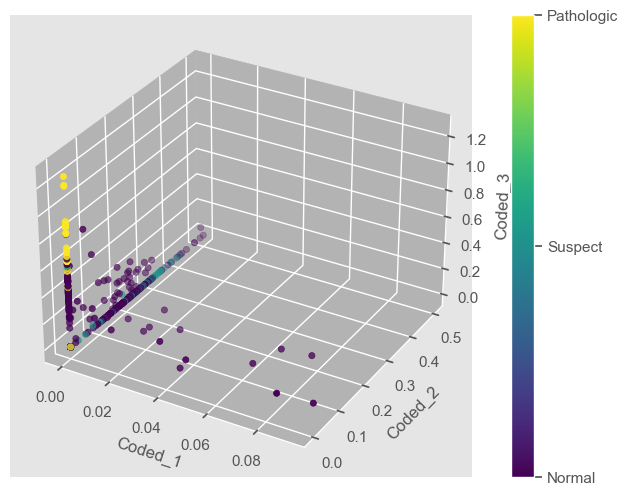

In [70]:
# Visualising the clusters
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style
style.use('ggplot')

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.w_xaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # During the previous visualisation
ax1.w_yaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # the colors were difficult to see
ax1.w_zaxis.set_pane_color((0.7, 0.7, 0.7, 1.0)) # with the light gray background, color tuning

x3d = encoded_out[:,0]
y3d = encoded_out[:,1]
z3d = encoded_out[:,2]

plot = ax1.scatter(x3d, y3d, z3d, c=y_test_auto, cmap="viridis", marker='o')
ax1.set_xlabel('Coded_1')
ax1.set_ylabel('Coded_2')
ax1.set_zlabel('Coded_3')
cb = plt.colorbar(plot)
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.show()

The results of the dimensionalty reduction using the autoencoder are not as expected but can still provide interesting insights.
We could have expected three different clusters for the three NSP classes, or even ten clusters for the ten fetus classes. Instead we can see around seven clusters. All of them could be understood as their own particular class with different risks for the fetus. 
For example, we find a cluster of suspect cases that is very close to the cluster of pathological cases, they could be interpreted as highly suspect and hence refine or even re-define the classes we used before, would it be for pathological classification or for the fetus classifiaction.
We decided to use the k-means algorithm to efficiently label the groups we found using the autoencoder. We will then insert these new classes in our dataset and study them to see if they can describe the problem in a more efficient way.

Now that the new groups have been defined, we will insert them into our dataset and study them the same way we studied the fetus classes given in the dataset. This way we will be able to compare the labelling of the problem and see if the groups found by the autoencoder and by the k-means can represent the problem in a more efficient way.

The new groups we previously found while using the autoencoder manage to describe the problem under a new light. While previously our fetus classes were made according to the fetus behavior, these ones have been made with a focus on the possibility of a disease. Much like a BIRADS classification used to describe the risk of breast cancer in a patient, these new classes could allow us to do a statistical risk classification for fetuses.

0 : No risks at all, Group 4

1 : Almost no risks, Group 5 & Group 6

2 : Small risk of pathology, Group3

3 : Verified risk of pathology, Group2

4 : Very high risk of pathology, Group 1

5 : Pathology detected, Group 7

For a more accurate classification we could use a bigger test sample and see how the AE behaves. Could we get more classes ? Less ? A better definition of the previous classes ? What if we tried with a different type of distance for the AE ? Or for the k-means ? We want to keep this simple so we will not explore these possibilities right now, instead, we will keep an eye on the new groups we created while solving the classification problem when it comes to NSP.


**Comparing the AE clusters with the classes given in the dataset**

Overall the clusters we found using the AE behave quite similarly to the ones that were given with the dataset with one little difference. These new clusters focus on a statistical approach of the problem as we explained above. They do not describe entirely the fetus but describe the risk of a pathology. We can see that the main differences are present on the classes that previously presented the most suspect or pathological cases. "SUSP" has been replaced by a hig risk Group 1 that also includes parts of FS. "LD" seems to be entirely interchangeable with Group 7 and shows as we said earlier a verified patholgy in the fetuses. Eventually we realize that the "real" use for such new classes would only be for the last ones that split and refine the result of the suspect and pathological cases.

To conclude on this part, we saw that when the PCA fails to deliver meaningful results, the use of an autoencoder can not only prove efficient in the process of dimensionality reduction, but also can give us some very powerful insights.

**Finding the best classifier**
---
As a first part we're gonna implement an SVC and explain each line and each parameter chosen. In a second part we will test out all the classifiers that can apply to this problem that are in the sklearn library, pick out the best one and tune it to get the best results possible.

**Using an SVC**

The score is : 0.981203007518797


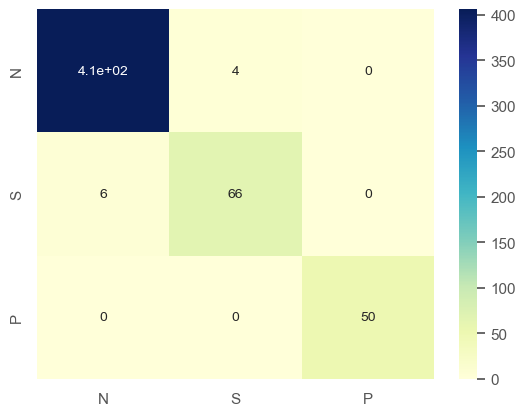

In [78]:
from sklearn.svm import SVC # Importing the relevant classifier
classifier = SVC(kernel = 'linear', random_state = 0) # Choosing a linear Kernel for SVC and not K-svc
classifier.fit(X_train, y_train)# Fitting the classifier onto our dataset
score = classifier.score(X_test, y_test, sample_weight=None) # Checking how well it did

# Predicting the Test set results
y_pred = classifier.predict(X_test) # Still all pretty good

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)

print('The score is : '+str(score))   
label = ["N","S","P"]
sns.heatmap(cm1, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
plt.show()

A score of 98.1%  is fairly high for a non tuned algorithm. It also got a perfect score when it comes to detecting cases classified as pathologic, which is exactly the kind of criteria we're looking for when making a medical classifier.
This score and this confusion matrix will be used in the next part as a comparison point with the other scores and confusion matrixes of other algorithms.

**Testing all the classifiers**

--------------------------------------------------------------------------------
ElasticNet Confusion Matrix


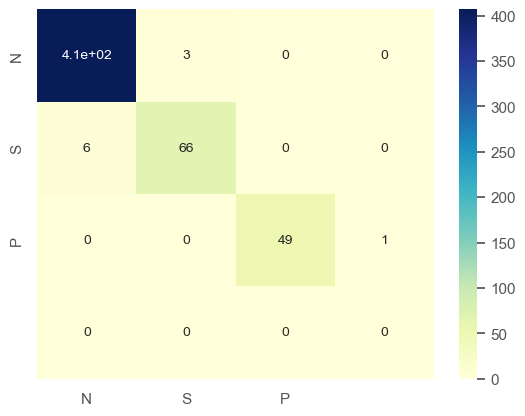

--------------------------------------------------------------------------------
ElasticNet Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.96      0.92      0.94        72
         3.0       1.00      0.98      0.99        50
         4.0       0.00      0.00      0.00         0

    accuracy                           0.98       532
   macro avg       0.74      0.72      0.73       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
ElasticNet Accuracy 98.12 %


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------
SVC Confusion Matrix


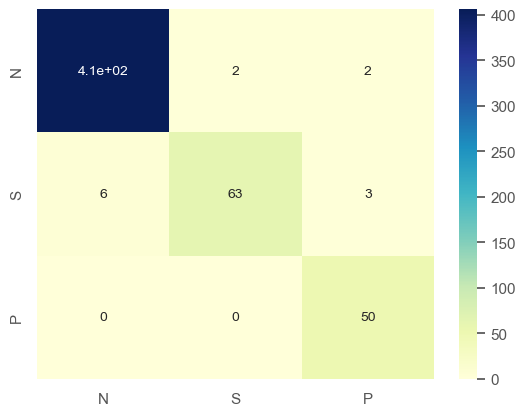

--------------------------------------------------------------------------------
SVC Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.97      0.88      0.92        72
         3.0       0.91      1.00      0.95        50

    accuracy                           0.98       532
   macro avg       0.95      0.96      0.95       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
SVC Accuracy 97.56 %
--------------------------------------------------------------------------------
kSVC Confusion Matrix


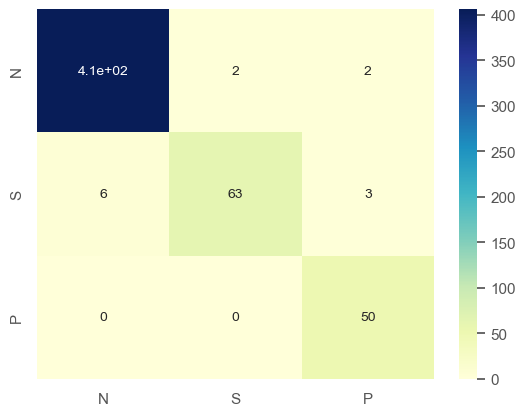

--------------------------------------------------------------------------------
kSVC Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       410
         2.0       0.97      0.88      0.92        72
         3.0       0.91      1.00      0.95        50

    accuracy                           0.98       532
   macro avg       0.95      0.96      0.95       532
weighted avg       0.98      0.98      0.98       532

--------------------------------------------------------------------------------
kSVC Accuracy 97.56 %
--------------------------------------------------------------------------------
KNN Confusion Matrix


AttributeError: 'NoneType' object has no attribute 'split'

In [79]:
# Importing all the classifiers fitting to the problem from sklearn                             
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Setting different parameters for the grid search
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

# Turning our problem into a non linear problem
n_col=36
poly = PolynomialFeatures(2)
X_train=poly.fit_transform(X_train)
X_test=poly.fit_transform(X_test)



names = [
         'ElasticNet',
         'SVC',
         'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         'GridSearchCV',
         'HuberRegressor',
         #♠'Ridge',
         'Lasso',
         'LassoCV',
         'Lars',
         'BayesianRidge',
         'SGDClassifier',
         'RidgeClassifier',
         ]

classifiers = [
    ElasticNetCV(cv=10, random_state=0),
    SVC(),
    SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    #Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True), # Seem to have problems with the Ridge, so I'm taking it out
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

models=zip(names,classifiers,correction)
   
for name, clf,correct in models:
    regr=clf.fit(X_train,y_train)
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
    
    # Confusion Matrix
    print('--'*40)
    print(name, 'Confusion Matrix')
    conf=confusion_matrix(y_test, np.round(regr.predict(X_test) ) )     
    label = ["N","S","P"]
    sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label, cmap="YlGnBu")
    plt.show()
    
    print('--'*40)

    # Classification Report
    print(name,'Classification Report')
    classif=classification_report(y_test,np.round( regr.predict(X_test) ) )
    print(classif)


    # Accuracy
    print('--'*40)
    logreg_accuracy = round(accuracy_score(y_test, np.round( regr.predict(X_test) ) ) * 100,2)
    print(name, 'Accuracy', logreg_accuracy,'%')